## Importing Required Libraries
In this section, we import various libraries that are essential for the audio processing and machine learning tasks in this project. The following libraries are used:

1. **`numpy`**: Provides support for arrays and matrices and a collection of mathematical functions to operate on these arrays.
2. **`matplotlib.pyplot`**: Used for creating visualizations like plots and graphs.
3. **`librosa` and `librosa.display`**: Used for analyzing and visualizing audio signals, including functionalities like Short-Time Fourier Transform (STFT), spectrogram generation, and more.
4. **`scipy.signal`**: Contains functions for signal processing, such as convolution and filtering.
5. **`sklearn.cluster.KMeans`**: Implements the K-Means clustering algorithm, which is used to cluster audio features.
6. **`cvxpy`**: A library for solving convex optimization problems, which may be applied in some of the optimization steps in the signal processing pipeline.
7. **`scipy.ndimage.convolve`**: Provides convolution operations, which are useful for filtering or smoothing data (e.g., applying a moving average or smoothing kernel).

These libraries provide the necessary tools for tasks such as signal processing, optimization, clustering, and visualization.


In [433]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal as signal
import numpy as np
from sklearn.cluster import KMeans
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cvxpy as cp
import numpy as np
import numpy as np
from scipy.ndimage import convolve


## Solvers Class for Signal Source Separation

The `Solvers` class is designed for solving signal source separation problems using various optimization techniques. It takes as input the **attenuation matrix**, **delays**, and **mixtures** (in their Short-Time Fourier Transform (STFT) form) and applies different optimization methods to estimate the original source signals. The methods available for optimization are:

### Class Initialization (`__init__`):
- **Attentuation**: Matrix of attenuation factors (m x n), where m is the number of mixtures, and n is the number of sources.
- **delays**: Matrix of delays (m x n) for the sources.
- **mixtures_stft**: Short-Time Fourier Transform (STFT) of the mixtures (m x time x frequency).
- **method_name**: Optimization method to use, which can be 'proximal', 'IRLS', or 'CVXPY'.
- **w_0**: Frequency-related computation parameter (default value is 1).
- **args**: Additional hyperparameters that can be passed to the optimization method.

### Optimization Methods:
The class supports three methods for solving the source separation problem:

1. **`IRLS`** (Iteratively Reweighted Least Squares):
   - A method that iteratively solves for source estimates by applying weighted least squares. The weights are updated in each iteration based on the current estimates.
   - The function **`IRLS`** takes the mixing matrix `A` and mixture vector `b`, then estimates the sources using the iterative reweighted approach.

2. **`solve_pq_optimization_proximal`**:
   - Applies the **proximal gradient descent** method to optimize the source estimates. The function uses a **proximal operator** to enforce sparsity on the source estimates using the `q`-norm.
   - This method is suitable for non-convex optimization problems with sparse solutions.

3. **`solve_pq_optimization`** (using **CVXPY**):
   - Uses convex optimization via the **CVXPY** library to minimize the **q-norm** of the source estimates.
   - The problem is solved with the constraint \( A \cdot s_e = x \), where `A` is the mixing matrix, `s_e` is the estimated source, and `x` is the mixture vector.

### Other Methods:
- **`A_l`**: Computes the mixing matrix at a specific time-frequency point based on the attenuation and delays.
- **`get_method`**: Selects the optimization method based on the provided `method_name`. This function returns the corresponding method (either `solve_pq_optimization_proximal`, `IRLS`, or `solve_pq_optimization`).
- **`__proximal_operator`**: Applies the proximal operator to enforce sparsity by penalizing the `q`-norm of the source estimate.
- **`__gradient_step`**: Performs one step of gradient descent to update the source estimate during the optimization process.

### Main Function (`solve`):
The **`solve`** method applies the selected optimization method to all time-frequency points in the mixtures' STFT. It iterates through each time-frequency point and computes the source estimates using the chosen method, then returns the estimated sources.

### Usage:
This class can be used to separate sources from mixed signals using optimization techniques based on the given attenuation, delays, and mixtures in their STFT form.



In [434]:

class Solvers:
    def __init__(self, Attentuation, delays, mixtures_stft, method_name, w_0=1, **args):
        """
        Initialize the solver with attenuation, delays, mixtures, and additional hyperparameters.
        
        Args:
        - Attentuation: Attenuation matrix (m x n).
        - delays: Delay matrix (m x n).
        - mixtures_stft: Short-time Fourier transform of mixtures.
        - method_name: Name of the method to use for optimization ('gard proximal', 'IRLS', or 'CVXPY').
        - w_0: A parameter for the frequency-related computation (default 1).
        - **args: Additional hyperparameters to be passed to the method.
        """
        self.Attentuation = Attentuation
        self.delays = delays
        self.mixtures_stft = mixtures_stft
        self.n_mix = Attentuation.shape[0]
        self.n_sources = Attentuation.shape[1]
        self.w_0 = w_0
        self.method_name = method_name
        self.args = args  # Store additional hyperparameters as a dictionary
        
    def get_method(self): 
        
        """
        Select the optimization method based on the provided method name.
        """
        if self.method_name == 'proximal': 
            return self.solve_pq_optimization_proximal
        elif self.method_name == 'IRLS': 
            return self.IRLS
        elif self.method_name == 'CVXPY':
            return self.solve_pq_optimization
        else:
            raise ValueError(f"Unknown method: {self.method_name}")
    
    def IRLS(self, A, b, **kwargs):
        """
        IRLS optimization function.
        
        Args:
        - A: Mixing matrix.
        - b: Mixture vector.
        - **kwargs: Additional hyperparameters for IRLS.
        
        Returns:
        - Estimated sources vector.
        """
        K = kwargs.get('K', 3)
        q = kwargs.get('q', 0.5)
        
        W = np.identity(A.shape[1])
        x_estim = np.ones(A.shape[1])
        
        for i in range(K):
            x_estim = W @ W @ A.T @ np.linalg.inv(A @ W @ W @ A.T) @ b
            z = np.abs(x_estim) ** (1 - q / 2)
            W = np.diag(z)
            
        return x_estim
    
    def A_l(self, l):
        """
        Compute the matrix A for a given time-frequency point [k, l].
        
        Args:
        - l: The time-frequency point index.
        
        Returns:
        - A_l: The computed mixing matrix at time-frequency point l.
        """
        A_l = np.zeros((self.n_mix, self.n_sources), dtype=complex)
        for i in range(self.n_mix):
            for j in range(self.n_sources):
                A_l[i, j] = self.Attentuation[i, j] * np.exp(-1j * 2 * np.pi * l * self.delays[i, j] * self.w_0)
        return A_l

    def __proximal_operator(self, x, **kwargs):
        """
        Proximal operator for the q-norm (non-convex for q < 1).
        
        Args:
        - x: The input vector (complex-valued).
        - **kwargs: Additional parameters like `q` and `lambda_param`.
        
        Returns:
        - The result of applying the proximal operator.
        """
        q = kwargs.get('q', 0.5)
        lambda_param = kwargs.get('lambda_param', 0.1)
        
        magnitude = np.abs(x)
        return np.sign(x) * np.maximum(magnitude - lambda_param, 0) ** q

    def __gradient_step(self, A, x, s_e, **kwargs):
        """
        Perform one step of the gradient descent.
        
        Args:
        - A: Mixing matrix.
        - x: Mixture vector.
        - s_e: Current source estimate.
        - **kwargs: Additional hyperparameters like learning_rate.
        
        Returns:
        - Updated s_e after the gradient descent step.
        """
        learning_rate = kwargs.get('learning_rate', 0.01)
        grad = A.T @ (A @ s_e - x)  # Compute the gradient of the loss
        return s_e - learning_rate * grad

    def solve_pq_optimization_proximal(self, A, x, **kwargs):
        """
        Solve the Pq optimization problem for a given time-frequency point using Proximal Gradient Descent.
        
        Args:
        - A: Mixing matrix at time-frequency point [k, l].
        - x: Mixture vector at time-frequency point [k, l].
        - **kwargs: Additional hyperparameters like `q`, `lambda_param`, `max_iter`, `learning_rate`.
        
        Returns:
        - s_e: Sparse source estimate at time-frequency point [k, l].
        """
        max_iter = kwargs.get('max_iter', 100)
        q = kwargs.get('q', 0.5)
        lambda_param = kwargs.get('lambda_param', 0.1)
        learning_rate = kwargs.get('learning_rate', 0.01)
        
        _, n = A.shape
        s_e = np.zeros(n, dtype=complex)
        
        for _ in range(max_iter):
            s_e = self.__gradient_step(A, x, s_e, learning_rate=learning_rate)
            s_e = self.__proximal_operator(s_e, q=q, lambda_param=lambda_param)
        
        return s_e

    def solve_pq_optimization(self, A, x, **kwargs):
        """
        Solve the Pq optimization problem for a given time-frequency point using CVXPY.
        
        Args:
        - A: Estimated mixing matrix at time-frequency point [k, l] (m x n).
        - x: Mixture vector at time-frequency point [k, l] (m x 1).
        - **kwargs: Hyperparameters for CVXPY optimization, like `q`, `epsilon`.
        
        Returns:
        - s_e: Sparse source estimate at time-frequency point [k, l].
        """
        q = kwargs.get('q', 0.5)
        epsilon = kwargs.get('epsilon', 1e-8)
        
        m, n = A.shape
        s_e = cp.Variable(n, complex=True)
        
        # Objective: Minimize the q-norm of s_e (sparsity measure)
        objective = cp.Minimize(cp.norm(cp.abs(s_e), q) + epsilon * cp.norm(s_e))
        
        # Constraint: A * s_e = x
        constraint = [A @ s_e == x]
        
        problem = cp.Problem(objective, constraint)
        problem.solve()
        
        return s_e.value

    def solve(self, **kwargs):
        """
        Apply the selected optimization method to all time-frequency points in the mixtures.
        
        Args:
        - **kwargs: Hyperparameters for the chosen method (q, lambda_param, max_iter, etc.)
        
        Returns:
        - estimated_sources: The estimated sources in the time-frequency domain.
        """
        estimated_sources = np.zeros((self.n_sources, self.mixtures_stft.shape[1], self.mixtures_stft.shape[2]), dtype=complex)
        
        for k in range(self.mixtures_stft.shape[2]):
            A_l = self.A_l(k)
            for l in range(self.mixtures_stft.shape[1]):
                x = np.array([self.mixtures_stft[i][l, k] for i in range(self.n_mix)])
                
                # Get the selected method and call it with the dynamic arguments
                method = self.get_method()
                s_e = method(A_l, x, **kwargs)
                
                estimated_sources[:, l, k] = s_e
        
        return estimated_sources
 

## System Class for Signal Source Separation

The `System` class is designed for signal source separation and reconstruction. It processes mixtures of signals and estimates the original sources by applying various algorithms like **Gabor Transform**, **K-means clustering**, and **source separation using different optimization methods**. The class uses the **Short-Time Fourier Transform (STFT)** and applies clustering techniques to extract features for separating sources.

### Class Initialization (`__init__`):
The constructor initializes the system with the following attributes:
- **`mixtures`**: The mixed signals that need to be separated.
- **`n_sources`**: The number of source signals.
- **`window_size`**: The window size used in STFT (default is 1024).
- **`hop_length`**: The hop length for STFT (default is 512).
- **`sr`**: The sample rate of the audio signals (default is 16,000 Hz).
- **`window_type`**: The type of window function used in STFT (default is Gaussian).

### Methods:

1. **`compute_gabor_transform_with_f_t`**:
   - Computes the Gabor transform (STFT) of the mixture signals.
   - This method generates the time-frequency representation of the mixture signals.

2. **`get_stfts`**:
   - Returns the computed STFT of the mixtures.

3. **`plot_mixtures_stft`**:
   - Plots the spectrogram (time-frequency representation) of the mixtures using STFT.

4. **`compute_feature_vectors`**:
   - Extracts feature vectors from the time-frequency representation of the mixtures.
   - Computes both the normalized STFT coefficients (attenuations) and phase differences (delays) between the mixtures.

5. **`compute_k_means`**:
   - Performs **K-means clustering** on the feature vectors to group similar time-frequency points into clusters.
   - This method assigns each time-frequency point to one of the `n_sources` clusters.

6. **`plot_clusters`**:
   - Visualizes the results of the K-means clustering in a 2D plot.
   - You can specify which features (dimensions) to plot using the `indx1` and `indx2` parameters.

7. **`estimate_aij_and_deltaij`**:
   - Estimates the attenuations and delays (source mixing parameters) based on the K-means clustering results.
   - These are used for reconstructing the sources from the mixtures.

8. **`Mean_S_E_without_print`**:
   - Computes the Mean Squared Error (MSE) between the estimated attenuations and delays and the true values.
   - This method is useful for assessing the accuracy of the estimated parameters without printing detailed information.

9. **`Mean_S_E`**:
   - Similar to `Mean_S_E_without_print`, but also prints the MSE and the estimated vs. true values of attenuations and delays.

10. **`ecarser_attentuation_delays`**:
   - Allows manually setting the estimated attenuations and delays if needed.

11. **`simulate_sources_stft`**:
   - Simulates the source signals' STFT using different optimization methods (e.g., **IRLS**, **proximal gradient descent**, **CVXPY**).
   - It applies the selected method to the attenuations and delays to reconstruct the source signals in the time-frequency domain.

12. **`get_sources_stft`**:
   - Returns the estimated source signals in their STFT form.

### Usage:
The class can be used for separating sources from mixtures of signals. It first computes the Gabor transform (STFT) of the mixtures, then extracts features, applies clustering, and estimates the source parameters (attenuations and delays). Finally, it uses an optimization method to reconstruct the sources.



In [435]:
class System:
    # Constructor (__init__) to initialize attributes
    def __init__(self,  mixtures, n_sources,window_size=1024,hop_length=512,sr=16000,window_type='gaussian'):
        self.n_sources=n_sources
        self.mixtures=mixtures     # Attribute for age
        self.n_mix= len(mixtures)
        self.A=np.zeros((self.n_mix,self.n_sources))
        self.hop_length=hop_length
        self.window_size=window_size
        self.sr= sr 
        self.f_0=sr / window_size
        self.window_type=window_type
        
    def compute_gabor_transform_with_f_t(self):
        gabor_transforms = []
        for signal_data in self.mixtures:
            if self.window_type == 'gaussian':
                window = signal.windows.gaussian(self.window_size, std=self.window_size / 4)
            else:
                window = signal.windows.get_window(self.window_type, self.window_size)
            self.f, self.t, Zxx = signal.stft(signal_data, nperseg=self.window_size, noverlap=self.hop_length, window=window)
            
            gabor_transforms.append(Zxx)
        self.mixtures_st_gabor=  np.array(gabor_transforms)
    def get_stfts(self):
        return  self.mixtures_st_gabor
    def plot_mixtures_stft(self,title=""):
        for i, stft in enumerate(mixtures_stft, 1):
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft), ref=np.max), sr=self.sr, x_axis='time', y_axis='log')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"{title} {i} Spectrogram (Gabor Transform)" if title!="" else "Spectrogram")
            plt.show()
    def compute_feature_vectors(self):
        n_bins, n_frames = self.mixtures_st_gabor[0].shape  # Frequency bins and time frames
        # Initialize an array to hold the feature vectors
        self.feature_vectors = []
        for k in range(n_frames):
            for l in range(1,n_bins):
                # Compute the norm of the mixture coefficients at [k, l]
                norm = np.linalg.norm([self.mixtures_st_gabor[i][l, k] for i in range(self.n_mix)])
                if norm ==0 : 
                    norm=1
                # Normalize each STFT coefficient
                feature_vector = [np.abs(self.mixtures_st_gabor[i][l, k]) / norm for i in range(self.n_mix)]
            # Compute the phase difference (delays) between the mixtures
                phase_diffs = []
                for i in range(1, self.n_mix):
                    # Compute phase difference for each mixture pair
                    if  self.mixtures_st_gabor[0][l, k]==0:
                        div= 1e-7
                        phase_diffs.append(0)  
                    else : 
                        phase_diffs.append(0) 
                        
                        #div=self.mixtures_st_gabor[0][l, k] 
                        #phase_diff = -np.angle(self.mixtures_st_gabor[i][l, k] / div)/ ( l*2*np.pi*self.sr/self.window_size)
############################################################################################################################################
#the w_0= ? , comment on définie la fréquence fondamentale !! cett valeurs affecte les phase_diff donc les features vectors en clustering. Ainsi , les clusters centers vont êtres affectés
#  Ainsi la matrice de reconstruction sera déphasée 
############################################################################################################################################
                        # Append the phase difference to the list
                        #phase_diffs.append(phase_diff)  
                if  np.any(np.isnan(phase_diffs)):
                    print( 'oh no the problem is from the source',k,l)
                # Combine the normalized features and phase differences into one feature vector
                feature_vector.extend(phase_diffs)
                self.feature_vectors .append(feature_vector)
        self.feature_vectors = np.array(self.feature_vectors )
        
    def compute_k_means(self): 
        self.k_means= KMeans(n_clusters=self.n_sources)# Perform k-means clustering on the feature vectors

        self.k_means.fit(self.feature_vectors)  # 'feature_vectors' are your time-frequency features

        # Get the cluster labels for each time-frequency point
        self.labels = self.k_means.labels_
        self.cluster_centers_=self.k_means.cluster_centers_
    def get_cluster_centers_(self):
        return self.cluster_centers_
    def plot_clusters(self,indx1=0, indx2=1):
        # Visualize the clustering (optional, for 2D representation)
        plt.figure(figsize=(8, 6))
        plt.scatter(self.feature_vectors[:, indx1], self.feature_vectors[:, indx2], c=self.labels, cmap='viridis')
        plt.title("Feature Vector Clustering (k-means)")
        plt.xlabel("Feature 1 (normalized STFT coefficient)")
        plt.ylabel("Feature 2 (phase difference)")
        plt.colorbar(label='Cluster')
        plt.show()

    def estimate_aij_and_deltaij(self ):
        # Initialize arrays to store the results
        self.attenuations_est = np.zeros((self.n_mix, self.n_sources))  # Estimated attenuations (aij) for each source and mixture
        self.delays_est = np.zeros((self.n_mix, self.n_sources ))    # Estimated delays (deltaij) for each source and mixtures

        for cluster_idx in range(self.n_sources):
            # Extract the cluster center for the current cluster
            self.cluster_center_ = self.cluster_centers_[cluster_idx]            
            # The first m elements correspond to the normalized STFT coefficients (attenuations)
            self.attenuations_est[:self.n_mix,cluster_idx]= self.cluster_center_[:self.n_mix]
            # The remaining m-1 elements correspond to the phase differences (delays)
            self.delays_est[1:self.n_mix,cluster_idx]= self.cluster_center_[self.n_mix:]
    def get_attentuations_and_delats(self):
        return self.attenuations_est, self.delays_est
    def Mean_S_E_without_print(self, Matrix_atten=None, Matrix_delays=None ):
        try:
            assert self.delays_est.shape == Matrix_delays.shape,"Matrices X and Y must have the same shape"
            self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
            
        except: 
            pass
        try:
                    assert self.attenuations_est.shape == Matrix_atten.shape,"Matrices X and Y must have the same shape"
                    self.mse = np.mean((self.attenuations_est - Matrix_atten)**2) /  np.mean( Matrix_atten**2)
                    
        except:
             pass 
        

    def Mean_S_E(self, Matrix_atten=None, Matrix_delays=None ):
        try:
            assert self.delays_est.shape == Matrix_delays.shape,"Matrices X and Y must have the same shape"
            self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
            print( "The mean suqare error of delays is ", self.mse)
            print("The True matrix is \n", Matrix_delays.T)
            print("The estiamted matrix is \n", self.delays_est.T)
        except: 
            pass
        try:
                    assert self.attenuations_est.shape == Matrix_atten.shape,"Matrices X and Y must have the same shape"
                    self.mse = np.mean((self.attenuations_est - Matrix_atten)**2) /  np.mean( Matrix_atten**2)
                    print( "The mean suqare error of attenutaion is ", self.mse)
                    print("The True matrix is \n", Matrix_atten.T)
                    print("The estiamted matrix is \n", self.attenuations_est.T)
        except:
             pass

    
    def ecarser_attentuation_delays( self, A=None,D=None): 
        if A != None: 
            self.attenuations_est= A 
        if D != None:
            self.delays_est= D
    
    def simulate_sources_stft(self,method_name='IRLS',method_params={}):
        if method_name == 'IRLS':
            solver_irls = Solvers(self.attenuations_est,self.delays_est, self.mixtures_st_gabor, method_name, w_0=2 * np.pi * self.f_0, **method_params)
            self.stft_sources = solver_irls.solve(**method_params)
        elif method_name == 'proximal':
            solver_proximal = Solvers(self.attenuations_est,self.delays_est,self.mixtures_st_gabor, method_name, w_0=2 * np.pi * self.f_0, **method_params)
            self.stft_sources = solver_proximal.solve(**method_params)
        elif method_name == 'CVXPY':
            solver_cvxpy = Solvers(self.attenuations_est,self.delays_est, self.mixtures_st_gabor, method_name='CVXPY', w_0=1, **method_params)
            self.stft_sources = solver_cvxpy.solve(**method_params)
        return self.stft_sources
    def get_sources_stft(self):
        return self.stft_sources

## Functions to Compute Gini Index

The following functions are used to compute the **Gini Index**, a measure of inequality or concentration in a dataset, commonly used in economics and signal processing.

### `Aire` Function:
The `Aire` function computes the area under the Lorenz curve. The Lorenz curve is used to visualize the distribution of a variable (such as wealth or income) and the Gini Index is derived from the area under the Lorenz curve.

- **Input**:
  - **`lorenz`**: An array representing the Lorenz curve (cumulative distribution).
  
- **Output**:
  - The area under the Lorenz curve, which is a key component in calculating the Gini Index.

- **Formula**:
  The area is calculated using the formula:

  \[
  A(x) = \frac{1}{2N} \sum \left(L(n - \frac{1}{N}) + L(\frac{n}{N}) \right)
  \]
  where \( L(n) \) is the Lorenz curve at position \( n \), and \( N \) is the total number of points.

### `gini_index` Function:
The `gini_index` function calculates the Gini Index based on the **Lorenz curve** and **Aire** function.

- **Input**:
  - **`A`**: A 1D array representing the data (e.g., signal amplitudes or any other variable).
  - **`matrix`**: A boolean indicating whether the input `A` is a matrix (default is `True`).

- **Output**:
  - The Gini Index, which is a measure of the concentration or inequality of the dataset.

- **Steps**:
  1. **Reshape**: If the data is a matrix, the function flattens it into a 1D array.
  2. **Sorting**: The data is sorted by its absolute value to compute the cumulative sum.
  3. **Cumulative Sum**: The cumulative sum of the sorted data is computed.
  4. **Lorenz Curve**: The Lorenz curve is generated by normalizing the cumulative sum.
  5. **Gini Index**: The Gini index is calculated using the formula:
  
  \[
  Gini = 1 - 2 \times A
  \]
  where \( A \) is the area under the Lorenz curve computed using the `Aire` function.


In [436]:
def Aire(lorenz):
    """Computes the area A(x) under the Lorenz curve using the formula:
        A(x) = 1 / (2N) * sum(L(n-1/N) + L(n/N)) for all n
    """
    N = len(lorenz) 
    area = 0
    for n in range(1, N+1):
        area += (lorenz[n-1] + lorenz[n-1 if n == N else n]) / N
    return 0.5 * area
def gini_index(A, matrix = True  ): 
    if  matrix : 
        A= A.reshape(-1)
    sorted_signal = np.sort(np.abs(A))
    cumulative_sum = np.cumsum(sorted_signal) 
    lorenz = cumulative_sum / cumulative_sum[-1]
    area = Aire(lorenz)
    gini = 1 - 2 * area
    return gini

## Signal Processing Functions

### `plot_time_domain_signals`
This function plots the time-domain signals for the given sources.

- **Arguments**:
  - `sources`: List or array of source signals to be plotted.
  - `sr`: Sample rate of the signals (default is 16,000 Hz).
  - `sr_or_mix`: A label that indicates whether the signals represent "sources" or "mixtures" (default is 'Source').

- **Description**:
  This function generates a figure with multiple subplots, each showing the time-domain signal of one of the sources (or mixtures). The signals are plotted in their original time domain.

### `delay_source`
This function applies a delay to a given source signal.

- **Arguments**:
  - `source`: The source signal to be delayed.
  - `rank`: The delay rank (in samples) to be applied to the source signal.

- **Description**:
  This function shifts the input source signal by a given delay (rank), setting the first `rank` samples to zero. The function returns the delayed signal.

### `simulate_mixing`
This function simulates the mixing process by applying a mixing matrix and delays to the source signals.

- **Arguments**:
  - `sources`: List or array of source signals to be mixed.
  - `mixing_matrix`: The matrix that defines how the sources are mixed (m x n, where m is the number of mixtures and n is the number of sources).
  - `delays`: Delay matrix (m x n) specifying the delay for each source in each mixture.
  - `sr`: Sample rate of the signals (default is 16,000 Hz).

- **Description**:
  This function simulates the mixing process by applying the given mixing matrix and delays to the source signals. The resulting mixtures are returned in a new matrix.

### `compute_gabor_transform_with_f_t`
This function computes the Gabor transform (STFT) of the given signals.

- **Arguments**:
  - `signals`: List or array of signals to be transformed.
  - `window_size`: Size of the window used in STFT (default is 1024).
  - `hop_length`: The hop length for the STFT (default is 512).
  - `window_type`: Type of window to be used for the STFT (default is 'gaussian').

- **Description**:
  This function computes the Gabor transform (Short-Time Fourier Transform) of the input signals. The function returns the Gabor transform for each signal, along with the frequency (`f`) and time (`t`) vectors.

### `plot_spectrogram`
This function plots the spectrogram (time-frequency representation) of a signal.

- **Arguments**:
  - `stft_matrix`: The Short-Time Fourier Transform (STFT) matrix of the signal.
  - `sr`: Sample rate of the signal (default is 16,000 Hz).
  - `title`: Title for the spectrogram plot (default is "Spectrogram").

- **Description**:
  This function generates a spectrogram plot using the amplitude of the STFT matrix, converting it to decibels for better visualization. The plot is displayed with time on the x-axis and frequency on the y-axis.

---

### Example Workflow:
1. **Mixing**: Using `simulate_mixing`, source signals are mixed according to a mixing matrix and delays.
2. **Transformation**: The `compute_gabor_transform_with_f_t` function is used to compute the Gabor transform (STFT) of the mixtures and sources.
3. **Plotting**: Both time-domain signals and spectrograms are plotted using `plot_time_domain_signals` and `plot_spectrogram`.


In [437]:
sr= 16000
def plot_time_domain_signals(sources, sr=sr, sr_or_mix= 'Source'):
    plt.figure(figsize=(10, 6))
    for i, source in enumerate(sources):
        plt.subplot(len(sources), 1, i + 1)
        plt.plot(source)
        plt.title(f"{sr_or_mix} {i + 1} - Time Domain")
    plt.tight_layout()
    plt.show()


In [438]:
def delay_source(source, rank ):
    delayed= np.roll(source, rank)
    delayed[0:rank]=np.zeros(rank)
    return delayed
# Function to simulate the mixing model

# Function to simulate the mixing model
def simulate_mixing(sources, mixing_matrix, delays, sr=16000):
    m, n = mixing_matrix.shape
    mixtures = np.zeros((m, len(sources[0])))  # Initialize mixtures matrix
    
    for i in range(m):
        for j in range(n):
            # Apply delays and attenuations
            delayed_source =  delay_source(sources[j],  int(delays[i, j] * sr)) 
            mixtures[i] += mixing_matrix[i, j] * delayed_source
    
    return mixtures



In [439]:

window_size= 1024
hop_length=512

# Function to compute the Gabor transform of signals
def compute_gabor_transform_with_f_t(signals, window_size=window_size, hop_length=hop_length, window_type='gaussian'):
    gabor_transforms = []
    for signal_data in signals:
        if window_type == 'gaussian':
            window = signal.windows.gaussian(window_size, std=window_size / 4)
        else:
            window = signal.windows.get_window(window_type, window_size)
        f, t, Zxx = signal.stft(signal_data, nperseg=window_size, noverlap=hop_length, window=window)
        
        gabor_transforms.append(Zxx)
    return np.array(gabor_transforms),f,t

# Function to plot the spectrogram of a signal
def plot_spectrogram(stft_matrix, sr=sr, title="Spectrogram"):
    plt.figure(figsize=(10, 6))
    
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()



## Signal Processing for Audio Source Separation

In this section, we load audio sources, compute their Short-Time Fourier Transform (STFT) using the Gabor transform, and analyze the results.

### Parameters:
1. **`method_names`**: A list of optimization methods available for source separation:
   - **'IRLS'**: Iteratively Reweighted Least Squares.
   - **'proximal'**: Proximal gradient descent.
   - **'CVXPY'**: Convex optimization via the CVXPY library.

2. **`method_parameters`**: Dictionary containing hyperparameters for each method:
   - **'proximal'**:
     - `q`: Regularization parameter (0.001).
     - `lambda_param`: Regularization factor (0.001).
     - `max_iter`: Number of iterations for the optimization (2 * 150).
   - **'IRLS'**:
     - `K`: Number of iterations (50).
     - `q`: Regularization parameter (0.5).
   - **'CVXPY'**:
     - `q`: Regularization parameter (1).
     - `epsilon`: Small value for numerical stability (1e-8).
   
3. **`eps`**: A threshold for the optimization process to stop if the error is smaller than 0.05.

4. **`sr`**: Sample rate for the audio signals (48,000 Hz).

5. **`n_sources`**: The number of source signals (3 sources).

6. **`n_mixtures`**: The number of mixed signals (2 mixtures).

7. **`duration`**: Duration of the signals to process (3 seconds).

8. **`N_essays`**: Number of essays or repetitions for averaging the results (10 essays).

9. **`taux_window`**: The time duration of each window in seconds (32 milliseconds).

10. **`window_size`**: The size of the window used in STFT (1024 samples).

11. **`hop_length`**: The number of samples to shift the window for the STFT (512 samples).

12. **`method`**: The optimization method selected for source separation (currently set to 'IRLS').

13. **`audio_paths`**: Paths to the audio files to be processed, which are **'sample-000002.mp3'**, **'sample-000013.mp3'**, and **'sample-000022.mp3'**.

14. **`folder_name`**: The name of the folder where results will be saved ('2+13+22').

### Functions:
1. **`read_sources`**: This function reads the audio files, extracts the first 3 seconds of each, and returns them as source signals.
   - The `librosa.load()` function is used to load the audio, and only the first 3 seconds of each signal are kept.

2. **`compute_gabor_transform_with_f_t`**: Computes the Short-Time Fourier Transform (STFT) of the source signals using the Gabor transform. 
   - This function returns the time-frequency representation of the signals and the corresponding time and frequency vectors.

3. **`gini_index`**: Calculates the Gini index for the STFT of each source. The Gini index is a measure of inequality, which is used to quantify the concentration of energy in different frequency bands.

4. **`plot_spectrogram`**: Plots the spectrogram (time-frequency representation) of the signals, displaying the amplitude in decibels.

### Workflow:
1. **Load Sources**: The audio sources are loaded from the specified paths and trimmed to the first 3 seconds.
2. **Compute STFT**: The Gabor transform (STFT) is computed for each source signal.
3. **Analyze Gini Index**: The Gini index of each source's STFT is calculated to assess how the energy is distributed across the frequency bands.
4. **Plot Spectrogram**: The spectrograms of the sources are plotted to visualize the time-frequency content of the signals.


In [440]:
method_names=['IRLS','proximal','CVXPY']
method_parameters={}
method_parameters['proximal']= {'q': 0.001, 'lambda_param': 0.001, 'max_iter': 2*150}

method_parameters['IRLS']= {'K': 50 , 'q': 0.5}
method_parameters['CVXPY']={'q': 1, 'epsilon': 1e-8}

the gini index of this stft =  0.93017723195503


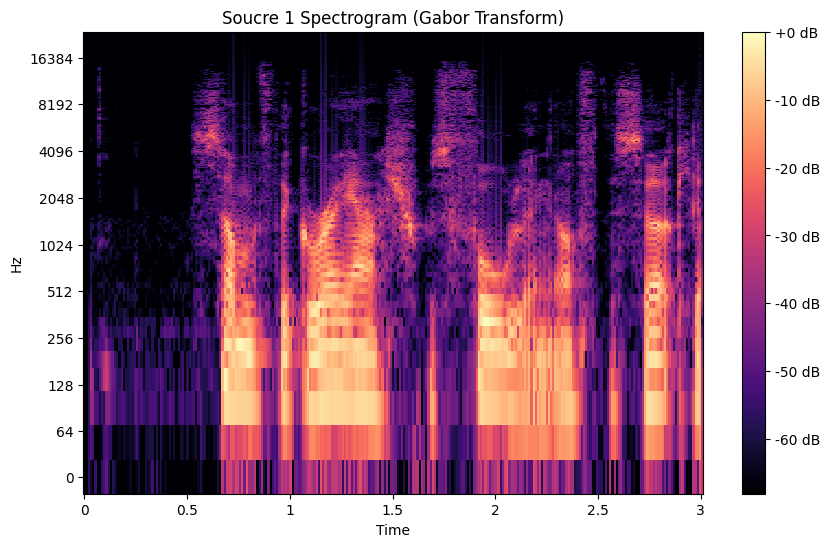

the gini index of this stft =  0.946595676099337


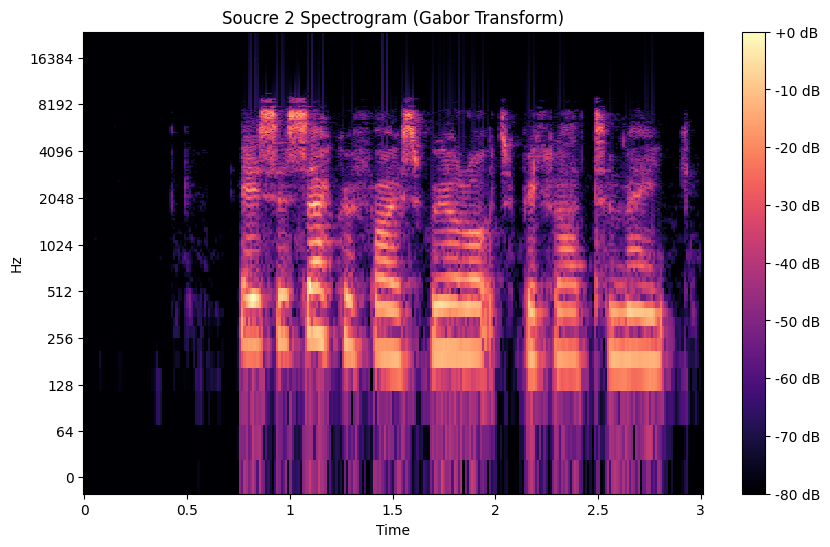

the gini index of this stft =  0.9394057670379011


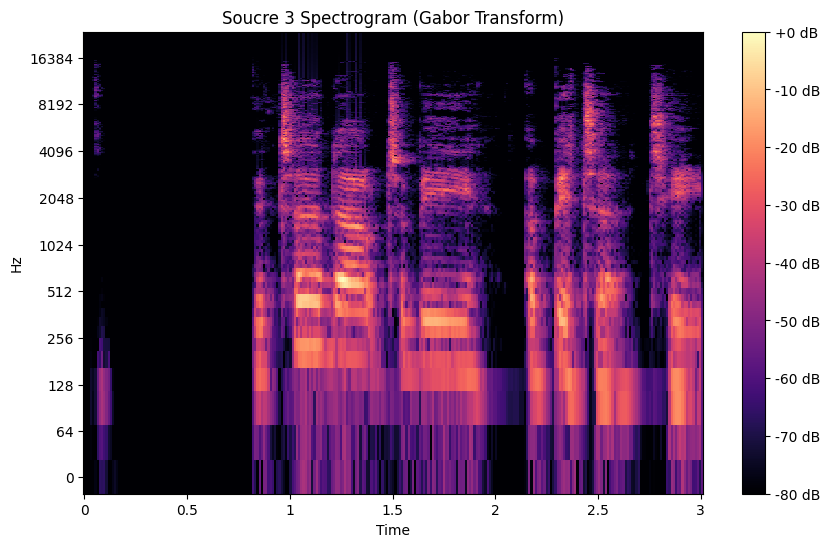

In [441]:
eps=0.05
sr= 48000
n_sources = 3
n_mixtures = 2 
duration = 3
N_essays= 10
taux_window= 32e-3
window_size= 1024
hop_length=512
#window_size= 1024
#hop_length=512
method= 'IRLS'
sr=48000
audio_paths=['sample-000022.mp3','sample-000023.mp3','sample-000028.mp3']
folder_name='22+23+28'
def read_sources(audio_paths=audio_paths, sr=sr):
    sources= []
    for audio_path in audio_paths:
        audio, sr = librosa.load(audio_path, sr=sr )  # sr is the sample rate (set to 16kHz)
        first_3_seconds = audio[:sr*3] 
        sources.append(first_3_seconds)
        
    sources=np.array(sources)
    return sources
sources= read_sources(audio_paths)


sources_stft,f,t = compute_gabor_transform_with_f_t(sources, window_size=window_size, hop_length=hop_length, window_type='gaussian')
for i, stft in enumerate(sources_stft, 1):
    print( "the gini index of this stft = ", gini_index(stft,matrix=True))
    plot_spectrogram(stft, sr=sr, title=f"Soucre {i} Spectrogram (Gabor Transform)")

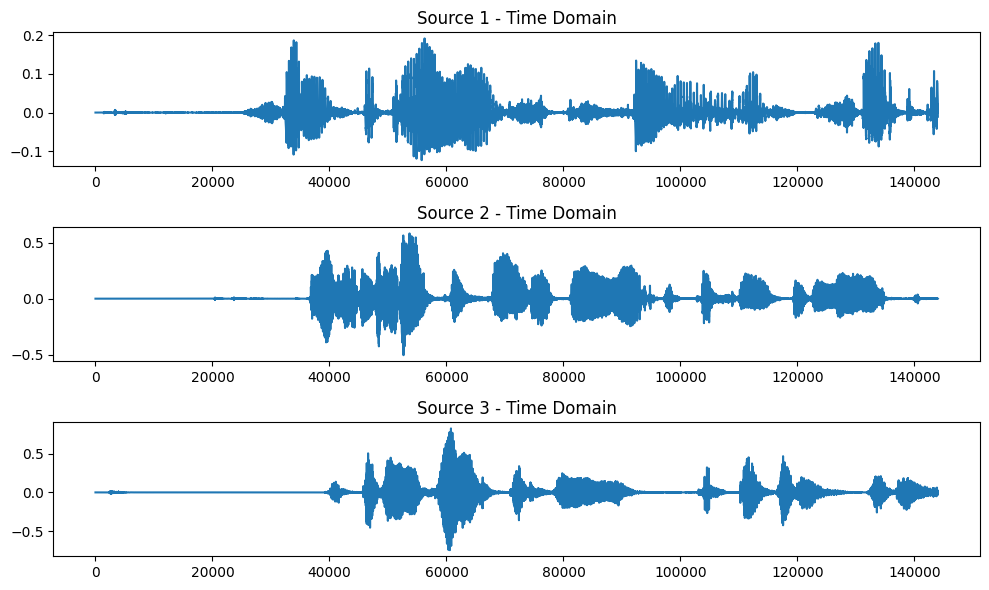

In [442]:
plot_time_domain_signals(sources, sr, 'Source')

## Signal Mixing and Source Separation

### Workflow:
1. **Mixing Process**:
   - A **random mixing matrix** is created for mixing the source signals. This matrix is normalized by dividing its columns by their L2-norm to ensure proper scaling.
   - A **delay matrix** is created, where all delays are set to 0 (i.e., no delay for now).
   - The `simulate_mixing` function is used to mix the sources based on the mixing matrix and delays, generating the **mixtures**.
   
2. **Plotting Time-Domain Mixtures**:
   - The `plot_time_domain_signals` function is used to plot the time-domain signals of the **mixtures**.

3. **Computing the Gabor Transform (STFT)**:
   - The `compute_gabor_transform_with_f_t` function computes the Short-Time Fourier Transform (STFT) for each mixture, transforming them into the time-frequency domain.

4. **Plotting Spectrogram of Mixtures**:
   - The `plot_spectrogram` function is used to visualize the spectrogram of each mixture. This helps in understanding the time-frequency distribution of the mixed signals.

5. **Source Separation**:
   - An instance of the `System` class is created with the **mixtures** and the number of sources.
   - The `compute_gabor_transform_with_f_t` and `compute_feature_vectors` methods are called to compute the time-frequency representations and feature vectors for the sources.
   - The system iterates through `N_essays` to compute the **k-means** clustering and estimate the attenuation and delay matrices using the `compute_k_means` and `estimate_aij_and_deltaij` methods.
   - The **best attenuation matrix** is selected based on the minimum mean square error (MSE), and the clustering results are visualized with the `plot_clusters` method for different pairs of indices.
   
6. **Computing the Mean Squared Error (MSE)**:
   - The `Mean_S_E` method is used to calculate the MSE between the estimated and true attenuation matrices.

7. **Simulating Sources**:
   - The `simulate_sources_stft` method is used to simulate the source signals based on the selected optimization method (IRLS, Proximal, or CVXPY).
   - The `get_sources_stft` method retrieves the estimated sources in the time-frequency domain.

8. **Plotting Spectrogram of Estimated Sources**:
   - The `plot_spectrogram` function is used again to visualize the time-frequency representations of the estimated sources.

### Notes:
- The `method` parameter can be set to one of the optimization methods available: **'IRLS'**, **'proximal'**, or **'CVXPY'**.
- The results are stored in `system1.mse`, which represents the Mean Squared Error (MSE) of the source separation for each optimization method.


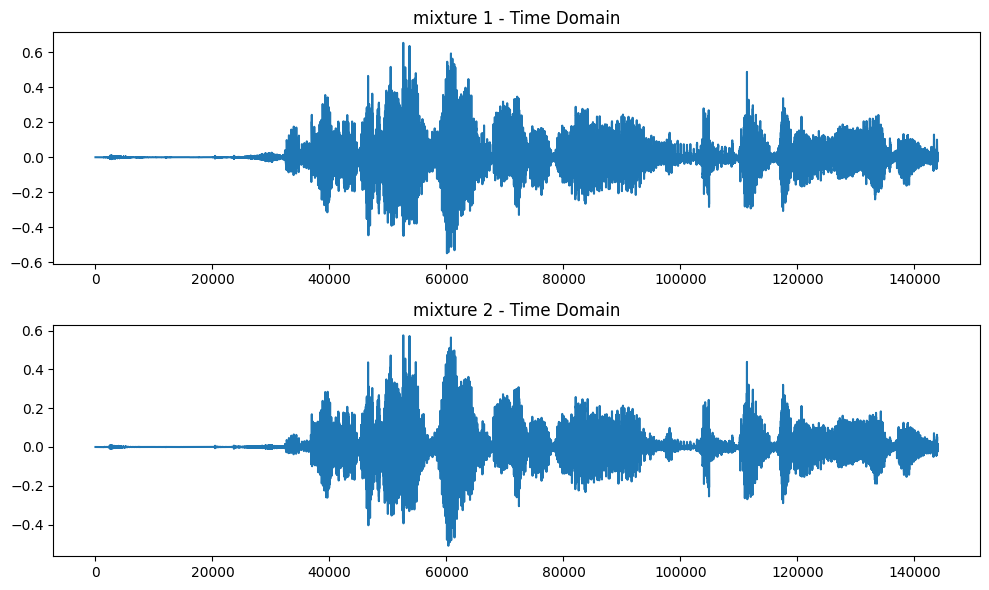

the gini index of this stft =  0.9137499256397943


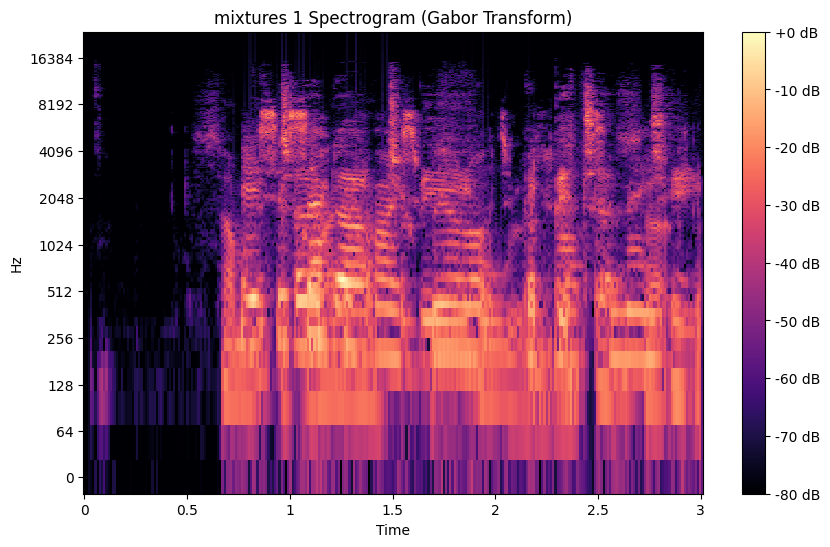

the gini index of this stft =  0.9184116558942627


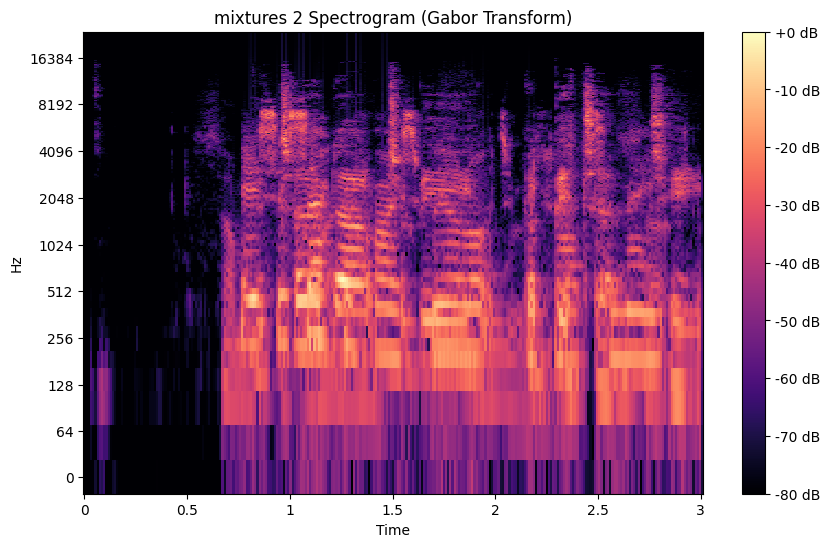

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12404\2054076689.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)


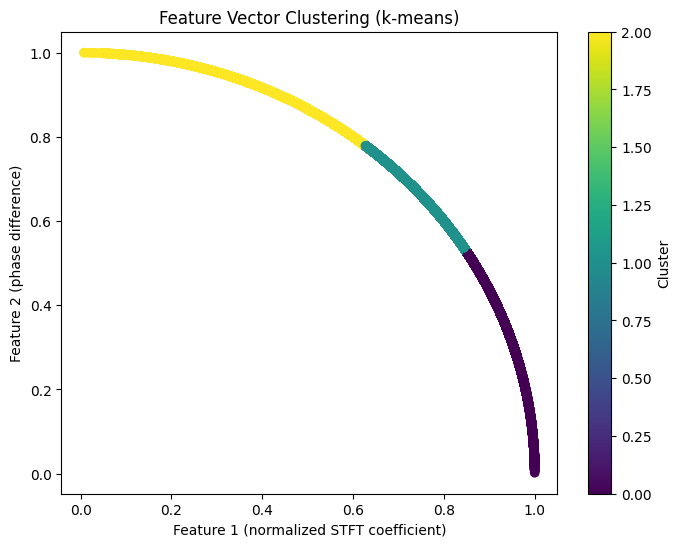

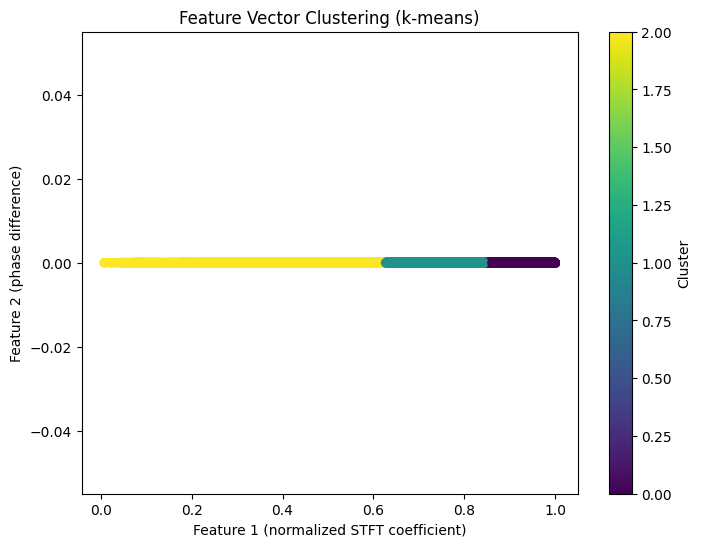

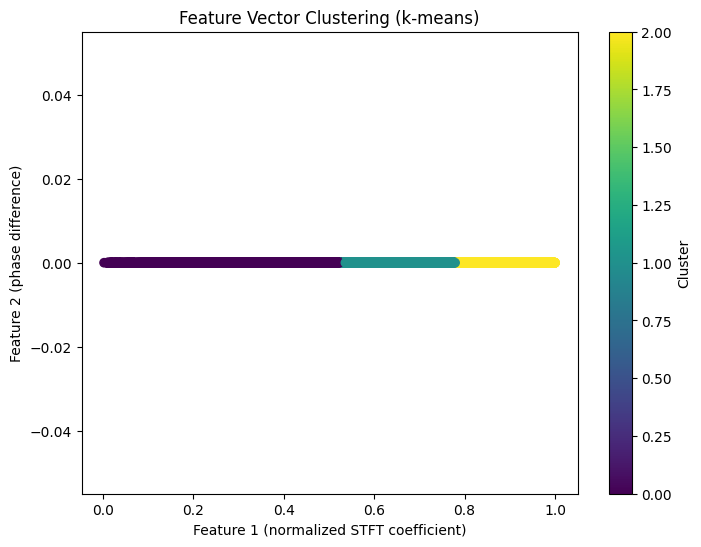

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12404\2054076689.py:123: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)


The mean suqare error of delays is  nan
The True matrix is 
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
The estiamted matrix is 
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
The mean suqare error of attenutaion is  0.031974539858447455
The True matrix is 
 [[0.93797143 0.34671255]
 [0.75724125 0.65313528]
 [0.72636327 0.68731099]]
The estiamted matrix is 
 [[0.92234025 0.3731524 ]
 [0.74826788 0.65996687]
 [0.47541542 0.86585567]]
The mean suqare error of attenutaion is  0.031974539858447455
the gini index of this stft =  0.9479441261206261


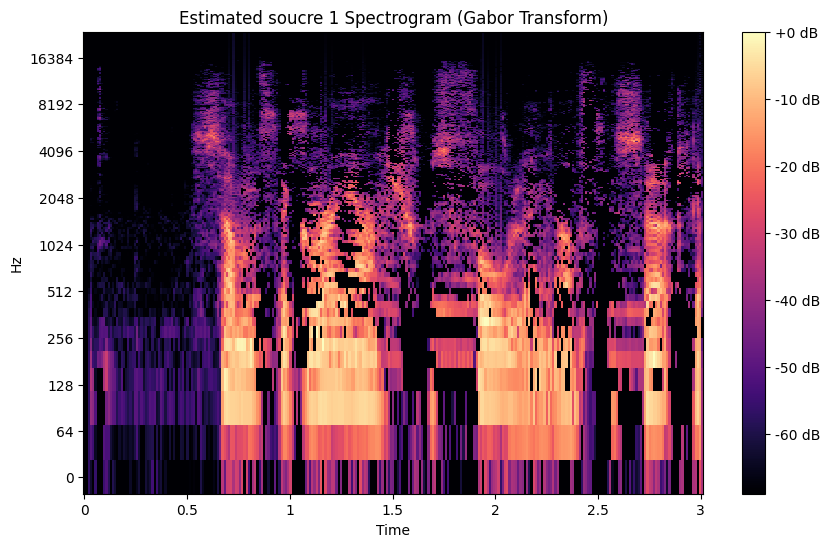

the gini index of this stft =  0.9394283192542683


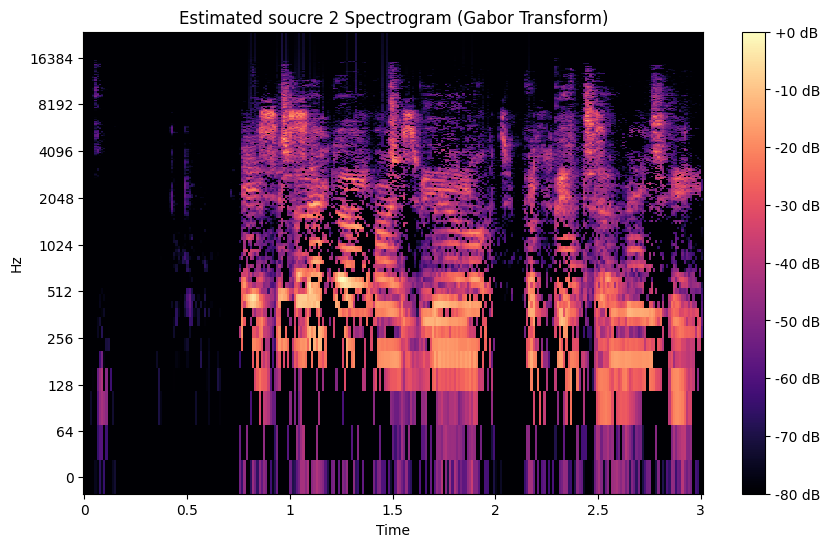

the gini index of this stft =  0.9409348511958185


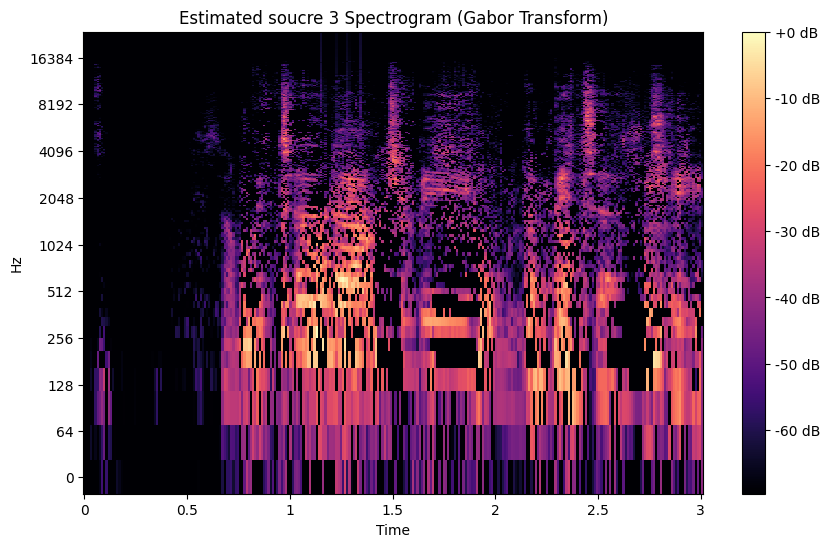

In [443]:
mixing_matrix = np.random.rand(n_mixtures, n_sources)  # Random mixing matrix
mixing_matrix = mixing_matrix / np.linalg.norm(mixing_matrix, axis=0)  # Normalize columns
delays = np.random.rand(n_mixtures, n_sources) *0 
mixtures = simulate_mixing(sources, mixing_matrix, delays, sr)
plot_time_domain_signals(mixtures, sr, 'mixture')

mixtures_stft,f,t = compute_gabor_transform_with_f_t(mixtures, window_size=window_size, hop_length=hop_length, window_type='gaussian')
for i, stft in enumerate(mixtures_stft, 1):
    print( "the gini index of this stft = ", gini_index(stft,matrix=True))
    plot_spectrogram(stft, sr=sr, title=f"mixtures {i} Spectrogram (Gabor Transform)")

system1= System(mixtures, n_sources, window_size= window_size,hop_length=hop_length,sr= sr)
system1.compute_gabor_transform_with_f_t()
system1.compute_feature_vectors()
best_mse=np.inf
best_attentuation= None
for _ in range(N_essays): 
    system1.compute_k_means()
    system1.estimate_aij_and_deltaij()
    system1.delays_est=system1.delays_est 
    system1.Mean_S_E_without_print(mixing_matrix,delays)
    if system1.mse < best_mse : 
        best_attentuation = system1.attenuations_est
    if system1.mse < eps : 
       break
system1.plot_clusters(indx1=0, indx2=1)
system1.plot_clusters(indx1=0, indx2=2)
system1.plot_clusters(indx1=1, indx2=2)
system1.attenuations_est= best_attentuation
system1.Mean_S_E(mixing_matrix,delays)
print( "The mean suqare error of attenutaion is ", system1.mse)
system1.simulate_sources_stft(method_name=method,method_params=method_parameters[method] )
rt=system1.get_sources_stft()
for i, stft in enumerate(rt, 1):
     print( "the gini index of this stft = ", gini_index(stft,matrix=True))
     plot_spectrogram(stft, sr=sr, title=f"Estimated soucre {i} Spectrogram (Gabor Transform)")




## Spectrogram Smoothing and Energy Distribution Analysis

In this section, we apply a smoothing operation to the spectrograms of the signals using a 3x3 kernel of ones. This smoothing is done using convolution to reduce noise and enhance the clarity of the time-frequency representations. After smoothing, we analyze the energy distribution of the signals by calculating the Gini index, which provides insights into how concentrated or dispersed the energy is across the frequency bands.

### Key Steps:
1. **Smoothing the Spectrograms**:
   - A **3x3 kernel** filled with ones is used to smooth the spectrograms by convolving it over the time-frequency slices of the spectrogram matrices.
   - The convolution is applied along the first axis (representing the sources).

2. **Energy Distribution Analysis**:
   - The **Gini index** is calculated for each smoothed spectrogram to measure the concentration of energy across the frequency bins.

3. **Visualization**:
   - The **smoothed spectrograms** are then visualized to assess the time-frequency structure after the smoothing operation.

### Objective:
- The goal is to reduce high-frequency noise and highlight the key features in the spectrograms for further analysis and source separation tasks.


In [444]:


# Define the 3x3 kernel of ones
kernel = np.ones((3, 3))/ 9

# Apply the kernel to each of the spectrogram slices in rt (axis 0)
# Since rt has shape (3, 513, 283), we need to apply the kernel to each 2D slice
# We apply convolution to each 2D array along the first axis (sources).
smoothed_rt = np.array([convolve(stft, kernel, mode='reflect') for stft in rt])
smoothed_rt=np.array(smoothed_rt)




the gini index of this stft =  0.9282397283087844


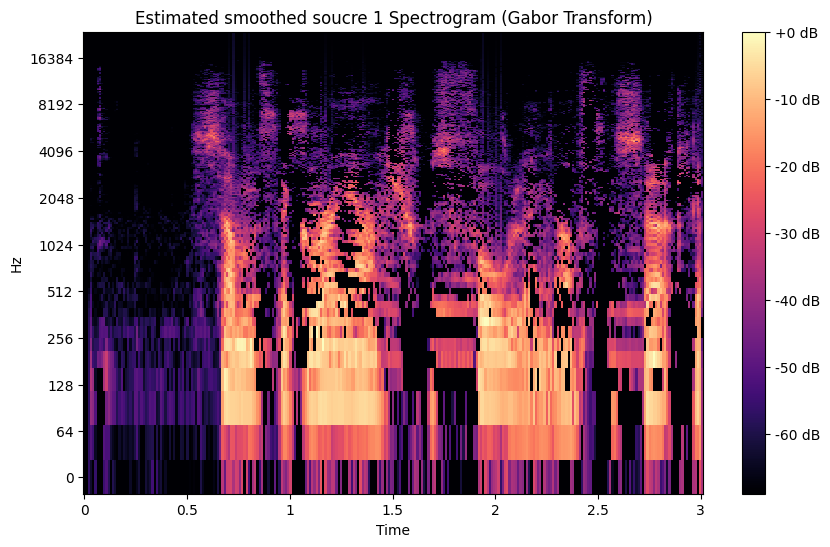

the gini index of this stft =  0.9282397283087844


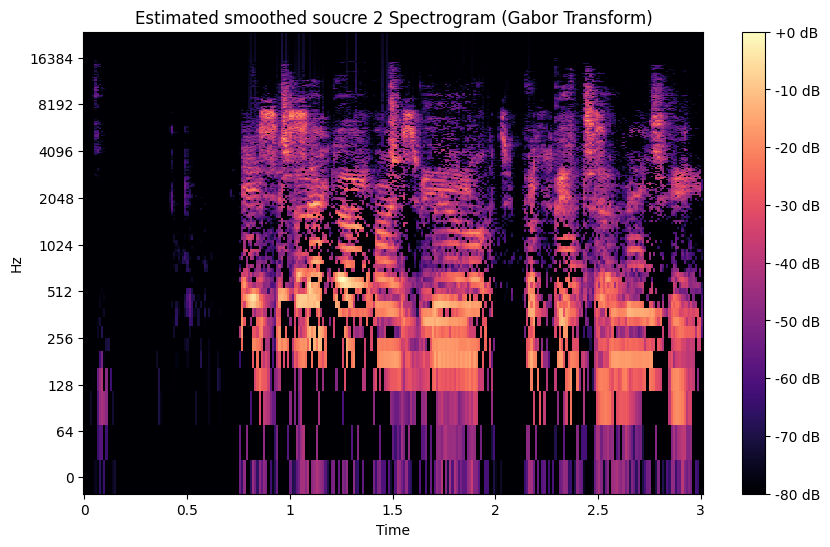

the gini index of this stft =  0.9282397283087844


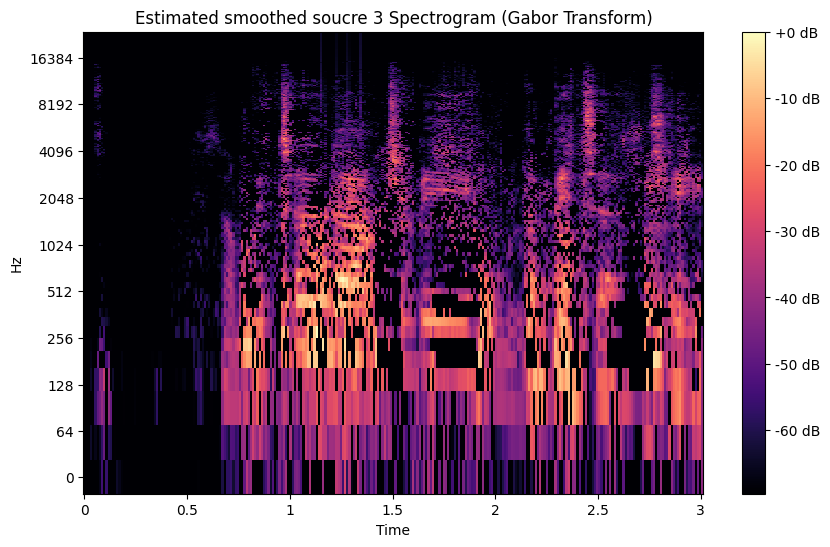

In [445]:
for i, stft in enumerate(rt, 1):
     print( "the gini index of this stft = ", gini_index(smoothed_rt,matrix=True))
     plot_spectrogram(stft, sr=sr, title=f"Estimated smoothed soucre {i} Spectrogram (Gabor Transform)")

## Signal Reconstruction and Playback

In this section, we reconstruct the signals from their Gabor transforms and listen to both the mixed and reconstructed signals. The process involves the following steps:

1. **Reconstruction of Signals**:
   - We first reconstruct the time-domain signals from their Gabor transforms using the inverse Short-Time Fourier Transform (STFT). The reconstruction helps in converting the time-frequency representation back into the original time-domain signal.

2. **Playback of Mixed Signals**:
   - The mixed signals, which are generated by combining different sources, are played to allow us to hear the original mixed signals before any processing or separation.

3. **Playback of Reconstructed Signals**:
   - After reconstructing the signals, we play them back to observe how well the signals have been recovered from their time-frequency representations.

4. **Playback of Smoothed Reconstructed Signals**:
   - The reconstructed signals are also processed with smoothing techniques to enhance the signal quality. We then listen to these smoothed signals to compare how the smoothing process affects the audio quality.

The purpose of this section is to allow us to compare the mixed signals, the reconstructed signals, and the smoothed reconstructed signals, helping us analyze the quality and effectiveness of the reconstruction and enhancement processes.


In [446]:
from IPython.display import Audio
def reconstruct_signal_from_gabor(gabor_transforms, window_size=1024, hop_length=512, window_type='gaussian'):
    reconstructed_signals = []
    
    for Zxx in gabor_transforms:
        if window_type == 'gaussian':
            window = signal.windows.gaussian(window_size, std=window_size / 4)
        else:
            window = signal.windows.get_window(window_type, window_size)

        # Inverse STFT to reconstruct the signal
        _, reconstructed_signal = signal.istft(Zxx, nperseg=window_size, noverlap=hop_length, window=window)
        reconstructed_signals.append(reconstructed_signal)
    
    return np.array(reconstructed_signals)


reconstructed_signals= reconstruct_signal_from_gabor(rt, window_size=1024, hop_length=512, window_type='gaussian')




In [447]:

# Play all reconstructed signals
for i, signal_r in enumerate(mixtures):
    print(f"Playing mixed signal {i+1}")
    display(Audio(signal_r, rate=sr))  # Display the audio player for each signal


Playing mixed signal 1


Playing mixed signal 2


In [448]:
smothed_reconstructed_signals= reconstruct_signal_from_gabor(smoothed_rt, window_size=1024, hop_length=512, window_type='gaussian')
# Play all reconstructed signals
for i, signal_r in enumerate(reconstructed_signals):
    print(f"Playing reconstructed signal {i+1}")
    display(Audio(signal_r, rate=sr))  # Display the audio player for each signal

Playing reconstructed signal 1


Playing reconstructed signal 2


Playing reconstructed signal 3


In [449]:
smothed_reconstructed_signals= reconstruct_signal_from_gabor(smoothed_rt, window_size=1024, hop_length=512, window_type='gaussian')
# Play all reconstructed signals
for i, signal_r in enumerate(smothed_reconstructed_signals):
    print(f"Playing reconstructed signal {i+1}")
    display(Audio(signal_r, rate=sr))  # Display the audio player for each signal

Playing reconstructed signal 1


Playing reconstructed signal 2


Playing reconstructed signal 3


## Saving Spectrograms, Signals, and Sources as WAV Files

### Workflow:

This section outlines the process of saving the following elements as files:

1. **Saving Spectrograms of Signals**:
   - This process generates and saves the spectrograms of the source signals, mixtures, estimated Short-Time Fourier Transform (STFT), and smoothed reconstructed STFTs.
   - Spectrograms are saved as images in a specified folder. Each image represents the time-frequency representation of the corresponding signal.

2. **Saving Signals as WAV Files**:
   - The signals (mixtures, reconstructed signals, and smoothed reconstructed signals) are saved as `.wav` files. 
   - The WAV files are stored in a user-specified folder for further analysis or playback.

3. **Saving Sources as WAV Files**:
   - The source signals are saved as individual `.wav` files. Each file corresponds to a specific source and is saved with its respective name in the chosen folder.

### Purpose:
This section ensures that the generated signals (mixtures, reconstructed, and smoothed signals) and their corresponding spectrograms are saved for future use, allowing easy access for further analysis or listening.


In [450]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os 

def save_stft_images(sources, mixtures, rt, rt_smoothed, sr, folder_name,  window_size=1024, hop_length=512):
    """
    This function takes sources, mixtures, rt (estimated STFT), and rt_smoothed (smoothed STFT),
    computes their STFT, and saves the spectrograms as images.

    Args:
    - sources: List or array of source signals.
    - mixtures: List or array of mixture signals.
    - rt: Estimated STFT of the sources.
    - rt_smoothed: Smoothed STFT of the sources.
    - sr: Sample rate of the signals.
    - window_size: Window size for STFT.
    - hop_length: Hop length for STFT.
    """
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    # Function to compute STFT and save spectrogram as image
    def plot_and_save_stft(stft, label, index, file_prefix):
        
        # Convert to amplitude and compute decibel scale
        stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        
        # Plot and save the spectrogram as an image
        plt.figure(figsize=(10, 6))
        librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{file_prefix} - {label} {index} Spectrogram")
        plt.savefig(f"{folder_name}/{file_prefix}_{label}_{index}.png")  # Save as PNG
        plt.close()

    # Save spectrograms for sources
    for i, source in enumerate(sources, 1):
        plot_and_save_stft(source, '', i, 'Source')

    # Save spectrograms for mixtures
    for i, mixture in enumerate(mixtures, 1):
        plot_and_save_stft(mixture, '', i, 'Mixture')

    # Save spectrograms for rt (estimated STFT)
    for i, stft in enumerate(rt, 1):
        plot_and_save_stft(stft, '', i, 'Estimated')

    # Save spectrograms for rt_smoothed (smoothed STFT)
    for i, stft in enumerate(rt_smoothed, 1):
        plot_and_save_stft(stft, 'smoothed', i, 'Estimated')



# Example usage:
save_stft_images(sources_stft , mixtures_stft , rt, smoothed_rt, sr,folder_name)


In [451]:
import soundfile as sf
import numpy as np

def save_signals_as_wav( mixtures, reconstructed_signals, smoothed_reconstructed_signals, sr, folder_name):
    """
    This function takes the sources, mixtures, reconstructed signals, and smoothed reconstructed signals,
    and saves each as a .wav file in the specified folder.

    Args:
    - sources: List or array of source signals.
    - mixtures: List or array of mixture signals.
    - reconstructed_signals: List or array of reconstructed signals.
    - smoothed_reconstructed_signals: List or array of smoothed reconstructed signals.
    - sr: Sample rate of the signals.
    - folder_name: Folder name where the .wav files will be saved.
    """
    # Create the folder if it doesn't exist
    import os
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Function to save signal as .wav
    def save_as_wav(signal, label, index, file_prefix):
        file_name = f"{folder_name}/{file_prefix}_{label}_{index}.wav"
        sf.write(file_name, signal, sr)  # Save the signal as a .wav file
        print(f"Saved {label} {index} as {file_name}")


    # Save mixtures
    for i, mixture in enumerate(mixtures, 1):
        save_as_wav(mixture, '', i, 'mixture')

    # Save reconstructed signals
    for i, reconstructed_signal in enumerate(reconstructed_signals, 1):
        save_as_wav(reconstructed_signal, '', i, 'reconstructed')

    # Save smoothed reconstructed signals
    for i, smoothed_signal in enumerate(smoothed_reconstructed_signals, 1):
        save_as_wav(smoothed_signal, '', i, 'smoothed_reconstructed')

# Example usage:

save_signals_as_wav(mixtures, reconstructed_signals, smothed_reconstructed_signals, sr, folder_name)


Saved  1 as 22+23+28/mixture__1.wav
Saved  2 as 22+23+28/mixture__2.wav
Saved  1 as 22+23+28/reconstructed__1.wav
Saved  2 as 22+23+28/reconstructed__2.wav
Saved  3 as 22+23+28/reconstructed__3.wav
Saved  1 as 22+23+28/smoothed_reconstructed__1.wav
Saved  2 as 22+23+28/smoothed_reconstructed__2.wav
Saved  3 as 22+23+28/smoothed_reconstructed__3.wav


In [452]:
import os
import soundfile as sf

def save_sources_as_wav(sources, source_names, folder_name, sr):
    """
    This function takes sources and their names, and saves them as .wav files in the specified folder.

    Args:
    - sources: List or array of source signals.
    - source_names: List of names corresponding to the source signals.
    - folder_name: Folder name where the .wav files will be saved.
    - sr: Sample rate of the signals.
    """
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Function to save signal as .wav
    def save_as_wav(signal, name, file_prefix):
        file_name = f"{folder_name}/{file_prefix}_{name}.wav"
        sf.write(file_name, signal, sr)  # Save the signal as a .wav file
        print(f"Saved {name} as {file_name}")

    # Save sources
    for i, (source, name) in enumerate(zip(sources, source_names), 1):
        save_as_wav(source, name, 'source')

# Example usage:
  # Replace these with actual source signals
source_names = [audio_paths[i][:-4]+'.wav' for i in range(len(audio_paths))]  # Names of the sources

save_sources_as_wav(sources, source_names, folder_name, sr)


Saved sample-000022.wav as 22+23+28/source_sample-000022.wav.wav
Saved sample-000023.wav as 22+23+28/source_sample-000023.wav.wav
Saved sample-000028.wav as 22+23+28/source_sample-000028.wav.wav


In [453]:
source_names = [audio_paths[i][:-4]+'.wav' for i in range(len(audio_paths))]
source_names

['sample-000022.wav', 'sample-000023.wav', 'sample-000028.wav']